In [469]:
import numpy as np
import pandas as pd
import requests
import os
import glob
import statsmodels.api as sm
import matplotlib.pyplot as plt

# GATHER DATA

#### File on Hand

In [470]:
df_archive_og = pd.read_csv('twitter-archive-enhanced.csv')

#### File obtained through Request Library

In [474]:
folder_name = 'image_prediction'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [475]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [476]:
df_image_og = pd.read_csv('image_prediction/image-predictions.tsv', sep = '\t')

#### File obtained through Tweepy (I could not get it working, so I uploaded the provided .txt, as instructed in 4. Twitter API)

In [477]:
# List of dictionaries to build file by file and later convert to a DataFrame
df_list = []
file = open('tweet-json.txt')
for line in file:
    
    substring1 = '"id": '
    substring2 = ', "id_str"'
    tw_id = line[(line.index(substring1)+len(substring1)):line.index(substring2)]

    substring1 = '"retweet_count": '
    substring2 = ', "favorite'
    tw_retweet = line[(line.index(substring1)+len(substring1)):line.index(substring2)]

    substring1 = '"favorite_count": '
    substring2 = ', "favorited'
    tw_favorite = line[(line.index(substring1)+len(substring1)):line.index(substring2)]

    df_list.append({'tweet_id': tw_id,
                    'retweet_count': tw_retweet,
                    'favorite_count': tw_favorite})
file.close()

df_stats_og = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [478]:
df_archive_og.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [479]:
df_archive_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [480]:
df_image_og.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [481]:
df_image_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [482]:
df_stats_og.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [483]:
df_stats_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [484]:
# Create copies for wrangling
df_archive = df_archive_og.copy()
df_image = df_image_og.copy()
df_stats = df_stats_og.copy()

# ASSESS DATA

### **Tidiness**

In [485]:
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


- 1. Combine doggo/floofer/pupper/puppo into 1 dog_stage column

In [486]:
type(df_archive.tweet_id[0]), type(df_image.tweet_id[0]), type(df_stats.tweet_id[0])

(numpy.int64, numpy.int64, str)

- 2. Merge all 3 tables using `tweet id` as key

### **Quality**

In [487]:
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


1. `p1`, `p2`, `p3` in df_image are not all small case alphabets

In [488]:
type(df_archive.timestamp[0])

str

2. df_archive's `timestamp` column is registered as string. Change to `datetime`

3. Remove retweet rows

In [489]:
type(df_stats.retweet_count[0]), type(df_stats.favorite_count[0])

(str, str)

4. convert `retweet_count` and `favorite_count` to `int`

In [490]:
df_archive.expanded_urls.isnull().sum()

59

5. expanded_url missing values - fill with `https://twitter.com/dog_rates/status/` + `tweet_id`

In [491]:
df_archive.query('rating_numerator == 5')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Who keeps sending in pictures without dogs in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882...,5,10,None,None,None,None,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847...,5,10,None,doggo,None,pupper,None
1399,699691744225525762,NaN,NaN,2016-02-16 20:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dave. He's a tropical pup. Short lil l...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699691744...,5,10,Dave,None,None,None,None
1461,694925794720792577,NaN,NaN,2016-02-03 16:49:55 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Please only send in dogs. This t-rex is very s...,NaN,NaN,NaN,https://vine.co/v/iJvUqWQ166L,5,10,None,None,None,None,None
1508,691483041324204033,NaN,NaN,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When bae says they can't go out but you see th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691483041...,5,10,None,None,None,None,None
1583,687102708889812993,NaN,NaN,2016-01-13 02:43:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Army of water dogs here. None of them know whe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687102708...,5,10,None,None,None,None,None
1618,684969860808454144,6.849598e+17,4.196984e+09,2016-01-07 05:28:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For those who claim this is a goat, u are wron...",NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1619,684959798585110529,NaN,NaN,2016-01-07 04:48:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's a neat dog. No legs (tragi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684959798...,5,10,Jerry,None,None,None,None
1624,684880619965411328,NaN,NaN,2016-01-06 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a basking dino pupper. Looks powe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684880619...,5,10,None,None,None,pupper,None


6. rating_numerator is extracted incorrectly (13.5 as 5), re-extract from text using regex, drop numerator column (Ex. Row 45)

`This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10`

7. denominator serves no analytical purpose, it's merely there for laughs (fun factor), drop denominator column

8. Remove reply tweet rows

In [492]:
type(df_archive.tweet_id[0])

numpy.int64

9. cast `tweet_id` as string object as no calculations are being done on the numeric ids 

# CLEAN DATA

#### Define
Merge 3 dataframes into 1

#### Code

In [493]:
# convert df_stats tweet_id to int so we can merge
df_stats.tweet_id = df_stats.tweet_id.astype('int')

In [494]:
# Merge all 3 dataframe together using tweet_id as key
df_archive = pd.merge(df_archive, df_image, on = ['tweet_id'], how = 'left')
df_archive = pd.merge(df_archive, df_stats, on = ['tweet_id'], how = 'left')

#### Test

In [495]:
# test
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,3261,20562
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,2158,12041
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,16716,56848
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,4429,28226
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,7711,32467


#### Define
Get Rid of Retweet info rows and columns

#### Code

In [496]:
# get rid of rows with retweet tweets
df_archive = df_archive[df_archive.retweeted_status_id.isnull()]

In [497]:
# drop columns containing retweet information
df_archive.drop('retweeted_status_id', axis = 1, inplace = True)
df_archive.drop('retweeted_status_user_id', axis = 1, inplace = True)
df_archive.drop('retweeted_status_timestamp', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Test

In [498]:
# test
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                    

#### Define
rating_numerator is extracted incorrectly (example: 13.5 as 5), re-extract from text using regex into `score` column, drop numerator column (Ex. Row 45)

#### Code

In [499]:
df_archive['score'] = df_archive.text.str.extract('([0-9]+[\.]?[0-9]+)[/]', expand = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [500]:
# cast it as float
df_archive.score = df_archive.score.astype('float')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [501]:
# drop wrongly extracted numerator column
df_archive.drop('rating_numerator', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Test

In [502]:
type(df_archive.score[0])

numpy.float64

In [503]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf              

#### Define

- denominator serves no analytical purpose, it's merely there for laughs (fun factor), drop denominator column

#### Code

In [504]:
# drop denominator column and change numerator column name to "score"
df_archive.drop('rating_denominator', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Test

In [505]:
# test
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 26 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog             

#### Define
Complete missing expanded URLs

In [506]:
# 58 missing expanded URLs
df_archive.expanded_urls.isnull().sum()

58

#### Code

In [507]:
# separate df_archive into 2 parts: df_archive that has complete expanded url and df_urlfix that is missing expanded url
df_archive = df_archive[df_archive.expanded_urls.notnull()]
df_urlfix = df_archive[df_archive.expanded_urls.isnull()]

In [508]:
# cast df_urlfix's tweet_id to string so it can be added as a string
df_urlfix.tweet_id = df_urlfix.tweet_id.astype('str')

In [509]:
# make expanded url
df_urlfix.expanded_urls = 'https://twitter.com/dog_rates/status/' + df_urlfix.tweet_id

In [510]:
# cast df_urlfix tweet_id back to int so we can concatenate
df_urlfix.tweet_id = df_urlfix.tweet_id.astype('int')

In [511]:
# concatenate df_urlfix back into df_archive
df_archive = pd.concat([df_archive, df_urlfix], ignore_index = True)

#### Test

In [512]:
# test
df_archive.expanded_urls.isnull().sum()

0

#### Define
Get rid of Reply Tweet info and columns

#### Code

In [513]:
# get rid of reply tweets
df_archive = df_archive[df_archive.in_reply_to_user_id.isnull()]

In [514]:
# drop columns containing reply tweet information
df_archive.drop('in_reply_to_status_id', axis = 1, inplace = True)
df_archive.drop('in_reply_to_user_id', axis = 1, inplace = True)

In [515]:
# test
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2116
Data columns (total 24 columns):
tweet_id          2094 non-null int64
timestamp         2094 non-null object
source            2094 non-null object
text              2094 non-null object
expanded_urls     2094 non-null object
name              2094 non-null object
doggo             2094 non-null object
floofer           2094 non-null object
pupper            2094 non-null object
puppo             2094 non-null object
jpg_url           1971 non-null object
img_num           1971 non-null float64
p1                1971 non-null object
p1_conf           1971 non-null float64
p1_dog            1971 non-null object
p2                1971 non-null object
p2_conf           1971 non-null float64
p2_dog            1971 non-null object
p3                1971 non-null object
p3_conf           1971 non-null float64
p3_dog            1971 non-null object
retweet_count     2094 non-null object
favorite_count    2094 non-null 

#### Define
Drop Dupes and Missing info rows

#### Code

In [516]:
df_archive.dropna(inplace = True)
df_archive.drop_duplicates(inplace = True)

In [517]:
# test
df_archive.info(), df_archive.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 2111
Data columns (total 24 columns):
tweet_id          1566 non-null int64
timestamp         1566 non-null object
source            1566 non-null object
text              1566 non-null object
expanded_urls     1566 non-null object
name              1566 non-null object
doggo             1566 non-null object
floofer           1566 non-null object
pupper            1566 non-null object
puppo             1566 non-null object
jpg_url           1566 non-null object
img_num           1566 non-null float64
p1                1566 non-null object
p1_conf           1566 non-null float64
p1_dog            1566 non-null object
p2                1566 non-null object
p2_conf           1566 non-null float64
p2_dog            1566 non-null object
p3                1566 non-null object
p3_conf           1566 non-null float64
p3_dog            1566 non-null object
retweet_count     1566 non-null object
favorite_count    1566 non-null 

(None, 0)

#### Define
Capitalization of Image Prediction results are not synced in capitalization

#### Code

In [518]:
# Prediction item names to lowercase alphabets
df_archive.p1 = df_archive.p1.str.lower()
df_archive.p2 = df_archive.p2.str.lower()
df_archive.p3 = df_archive.p3.str.lower()

#### Test

In [519]:
# test
df_archive.p1.value_counts()

golden_retriever             132
labrador_retriever            86
pembroke                      83
chihuahua                     62
chow                          41
pug                           40
samoyed                       39
pomeranian                    38
toy_poodle                    32
malamute                      26
cocker_spaniel                25
french_bulldog                20
chesapeake_bay_retriever      20
siberian_husky                19
eskimo_dog                    18
german_shepherd               17
miniature_pinscher            17
cardigan                      16
staffordshire_bullterrier     16
teddy                         15
web_site                      14
shih-tzu                      14
rottweiler                    14
shetland_sheepdog             13
maltese_dog                   13
great_pyrenees                13
beagle                        13
kuvasz                        13
seat_belt                     12
basset                        12
          

#### Define
Store Doggo, Puppo, Pupper, Floofer columns into 1 "dog_stage" column

#### Code

In [520]:
# combine dog stage strings into one column
df_archive.doggo = df_archive.doggo + df_archive.floofer + df_archive.puppo + df_archive.pupper

In [521]:
# replace strings with their type
df_archive.doggo = df_archive.doggo.replace('NoneNoneNoneNone', 'None')
df_archive.doggo = df_archive.doggo.replace('doggoNoneNoneNone', 'doggo')
df_archive.doggo = df_archive.doggo.replace('NoneflooferNoneNone', 'floofer')
df_archive.doggo = df_archive.doggo.replace('NoneNonepuppoNone', 'puppo')
df_archive.doggo = df_archive.doggo.replace('NoneNoneNonepupper', 'pupper')

In [522]:
# test
df_archive.doggo.value_counts()

None                    1306
pupper                   163
doggo                     60
puppo                     21
doggoNoneNonepupper        7
floofer                    7
doggoNonepuppoNone         1
doggoflooferNoneNone       1
Name: doggo, dtype: int64

In [523]:
# Dogs with multiple dog stages will be listed as "multiple"
df_archive.doggo = df_archive.doggo.replace('doggoNoneNonepupper', 'multiple')
df_archive.doggo = df_archive.doggo.replace('doggoflooferNoneNone', 'multiple')
df_archive.doggo = df_archive.doggo.replace('doggoNonepuppoNone', 'multiple')

In [524]:
# Rename doggo column to dog_stage
df_archive.rename(columns = {'doggo' : 'dog_stage'}, inplace = True)

In [525]:
# Drop other dog stage columns
df_archive.drop('floofer', axis = 1, inplace = True)
df_archive.drop('pupper', axis = 1, inplace = True)
df_archive.drop('puppo', axis = 1, inplace = True)

#### Test

In [526]:
# test
df_archive.info(), df_archive.dog_stage.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 0 to 2111
Data columns (total 21 columns):
tweet_id          1566 non-null int64
timestamp         1566 non-null object
source            1566 non-null object
text              1566 non-null object
expanded_urls     1566 non-null object
name              1566 non-null object
dog_stage         1566 non-null object
jpg_url           1566 non-null object
img_num           1566 non-null float64
p1                1566 non-null object
p1_conf           1566 non-null float64
p1_dog            1566 non-null object
p2                1566 non-null object
p2_conf           1566 non-null float64
p2_dog            1566 non-null object
p3                1566 non-null object
p3_conf           1566 non-null float64
p3_dog            1566 non-null object
retweet_count     1566 non-null object
favorite_count    1566 non-null object
score             1566 non-null float64
dtypes: float64(5), int64(1), object(15)
memory usage: 269.2+ KB


(None, None        1306
 pupper       163
 doggo         60
 puppo         21
 multiple       9
 floofer        7
 Name: dog_stage, dtype: int64)

#### Define
Convert timestamp to datetime object

In [527]:
type(df_archive.timestamp[0])

str

#### Code

In [528]:
# convert timestamp to datetime
df_archive.timestamp = pd.to_datetime(df_archive.timestamp)

#### Test

In [529]:
# test
type(df_archive.timestamp[0])

pandas._libs.tslib.Timestamp

#### Define
Favorite and Retweet count are not of type 'int'

#### Code

In [530]:
df_archive.favorite_count = df_archive.favorite_count.astype('int')
df_archive.retweet_count = df_archive.retweet_count.astype('int')

#### Test

In [531]:
type(df_archive.favorite_count[0]), type(df_archive.retweet_count[0])

(numpy.int64, numpy.int64)

#### Define
tweet_id is not a string object (is int but no calculations are needed)

#### Code

In [532]:
df_archive.tweet_id = str(df_archive.tweet_id)

#### Test

In [533]:
type(df_archive.tweet_id[0])

str

### Save Clean Data

In [534]:
# Save wrangled file to csv
df_archive.to_csv('twitter_archive_master.csv', index = False)

### Analysis Topics
- Do tweets that are liked more (higher retweet/favorite count) have easier or harder time for AI to predict image as a dog? (Use logistic regression)
- Does higher score translate to more retweets? How about favorites? (Use correlation)
- `H1`: Pupper tweets significantly different favorite + retweet count as compared to other dog_stage dogs (Use t-test)

#### Analysis 1)

Do people like certain dog tweets more because they can be easily identified as dogs? (and thereby also easier for AI to detect the same image as containing a dog?) OR does that have no effect on the precision of the AI prediction model?

We will perform a logistic regression using result of the highest confidence value (p1_dog) and try and see if retweet and favorite count have any effect of the result.

In [535]:
# we are using a copy of df_archive for analysis
df_copy = df_archive
df_copy[['not_dog', 'dog']] = pd.get_dummies(df_copy.p1_dog) 

In [536]:
df_copy.drop('not_dog', axis = 1, inplace = True)

In [537]:
df_copy['intercept'] = 1

lm = sm.Logit(df_copy['dog'], df_copy[['intercept', 'retweet_count', 'favorite_count']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.181227
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    dog   No. Observations:                 1566
Model:                          Logit   Df Residuals:                     1563
Method:                           MLE   Df Model:                            2
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:               0.0008654
Time:                        04:07:11   Log-Likelihood:                -283.80
converged:                       True   LL-Null:                       -284.05
                                        LLR p-value:                    0.7821
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          1.3250      0.082     16.251      0.000       1.165       1.485
retweet_count  -8.768e-05   2.91e-05     -3.017      0.003      -0.000   -3.07e-05
favorite_count  3.142e-05    1.2e-05      2.615      0.009    7.87e-06     5.5e-05
==================================================================================
"""

With insignificant coefficient values for both retweets and favorites, whether people liked the tweet did not have any meaningful relationship with how accruate AI's image prediction was.

#### Analysis 2)

Does the tweet score have an actual meaning? Does it translate to higher retweet and favorite counts and vice verca? 

array([[ 1.        ,  0.00276869],
       [ 0.00276869,  1.        ]])

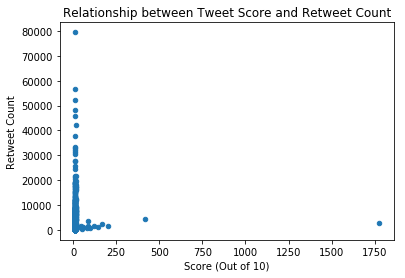

In [538]:
x = df_copy.score
y = df_copy.retweet_count
df_copy.plot(x = 'score', y = 'retweet_count', kind = 'scatter');
plt.title('Relationship between Tweet Score and Retweet Count');
plt.xlabel('Score (Out of 10)');
plt.ylabel('Retweet Count');
np.corrcoef(x,y)

In [539]:
df_archive.score.value_counts()

12.00      446
10.00      419
11.00      393
13.00      255
14.00       34
121.00       1
13.50        1
84.00        1
24.00        1
9.75         1
204.00       1
50.00        1
420.00       1
45.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
165.00       1
11.27        1
1776.00      1
99.00        1
80.00        1
Name: score, dtype: int64

This looks awful because there seem to be some outliers in scores. Let's fix that by removing all rows that have score higher than 24.

In [540]:
df_copy = df_copy[df_copy.score < 24]

array([[ 1.        ,  0.36655057],
       [ 0.36655057,  1.        ]])

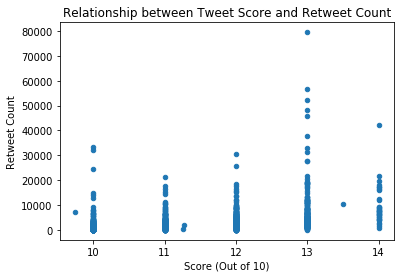

In [541]:
# Now let's do this again
x = df_copy.score
y = df_copy.retweet_count
df_copy.plot(x = 'score', y = 'retweet_count', kind = 'scatter');
plt.title('Relationship between Tweet Score and Retweet Count');
plt.xlabel('Score (Out of 10)');
plt.ylabel('Retweet Count');
np.corrcoef(x,y)

array([[ 1.        ,  0.49583053],
       [ 0.49583053,  1.        ]])

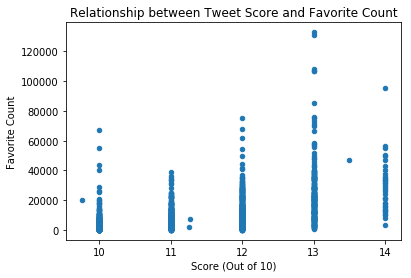

In [542]:
x = df_copy.score
y = df_copy.favorite_count
df_copy.plot(x = 'score', y = 'favorite_count', kind = 'scatter');
plt.title('Relationship between Tweet Score and Favorite Count');
plt.xlabel('Score (Out of 10)');
plt.ylabel('Favorite Count');
np.corrcoef(x,y)

In [543]:
# Lastly, let's combine retweets and likes and see if there is a stronger correlation here
df_copy['user_reaction'] = df_copy.favorite_count + df_copy.retweet_count

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[ 1.        ,  0.46812381],
       [ 0.46812381,  1.        ]])

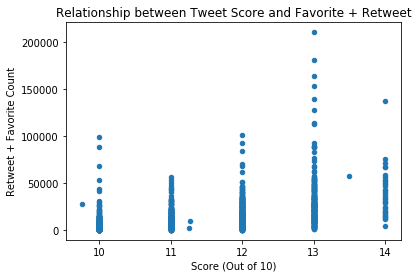

In [544]:
x = df_copy.score
y = df_copy.user_reaction
df_copy.plot(x = 'score', y = 'user_reaction', kind = 'scatter');
plt.title('Relationship between Tweet Score and Favorite + Retweet');
plt.xlabel('Score (Out of 10)');
plt.ylabel('Retweet + Favorite Count');
np.corrcoef(x,y)

We find moderate positive correlation between score and retweets (`0.367`), and score and favorites (`0.496`). Retweets and Favorites combined also showed moderate positive correlation with score (`0.468`)

#### Analaysis 3)

I want to examine the effect of kewpie doll effect, leading to possibly different amount of reaction to the tweet

`H0`: Tweets containing photo of pupper gets the same amount of favorites + retweets as other `dog_stage` tweets  
`H1`: Tweets containing photo of pupper gets significantly different amount of favorites + retweets as other `dog_stage` tweets

We will be using confidence interval of 0.05

In [545]:
from scipy import stats

#creating a df excluding tweets that do not have dog_stage information
df_a3 = df_copy[df_copy.dog_stage != 'None']

pupper_reaction = df_a3.query('dog_stage == "pupper"').user_reaction
rest_reaction = df_a3.query('dog_stage != "pupper"').user_reaction

ind_t_test = stats.ttest_ind(pupper_reaction, rest_reaction)
ind_t_test[0], ind_t_test[1]

(-5.2169591167627285, 3.7381117008155074e-07)

**t-value = -5.217  
p-value = 3.738-e07**  

Based on the values above, puppy (pupper) tweets are significantly less popular as compared to older dogs. With a p-value of `3.738 * 10^-7`, We reject the null hypothesis.

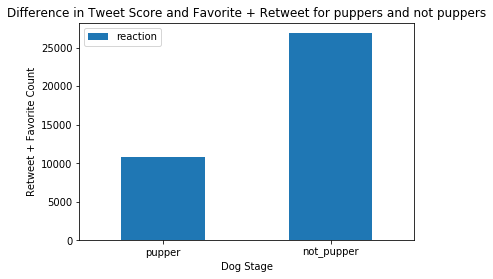

In [546]:
# create a new df (df_bar) to easily pass it into plot function
user_reaction = [df_a3.query('dog_stage == "pupper"').user_reaction.mean(), df_a3.query('dog_stage != "pupper"').user_reaction.mean()]
index = ['pupper', 'not_pupper']
df_bar = pd.DataFrame({'reaction': user_reaction}, index = index)

ax = df_bar.plot.bar(rot=0)
plt.title('Difference in Tweet Score and Favorite + Retweet for puppers and not puppers');
plt.xlabel('Dog Stage');
plt.ylabel('Retweet + Favorite Count');

And rightfully so when we take a look at a bar graph visualizing the difference in reactions for each type of tweets.